# Optimal Cluster Count Grid Search 
This notebook demonstrates how to efficiently determine clustering parameters using distributed grid search. Data is distributed across nodes, clustering algorithms like `k-means`  are applied, and results are evaluated with metrics such as silhouette score to identify the best configuration

In [ ]:
import sys
from functools import partial

import healpy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from furax import HomothetyOperator
from furax.comp_sep import (
    negative_log_likelihood,
    spectral_cmb_variance,
    spectral_log_likelihood,
)
from furax.obs.stokes import Stokes
from jax_grid_search import optimize
from jax_healpy import get_clusters

sys.path.append("../data")
from generate_maps import get_mask

# Load Planck Galactic Masks  
This cell loads Planck Galactic masks (`GAL020`, `GAL040`, `GAL060`) for NSIDE 64 from a `.npz` file. These masks are used to exclude regions of the sky with Galactic contamination.

In [ ]:
mask = get_mask("GAL020")

# Sky Component Simulation  
This cell defines parameters and simulates sky components (`cmb`, `dust`, `synchrotron`) for a specified NSIDE of 64. It generates random maps for each component in the `QU` Stokes parameterization across 15 frequency bands, with values ranging from 40 to 402 GHz. The sky maps are represented as instances of the `Stokes` class.

In [3]:
from generate_maps import load_from_cache

nside = 64
npixels = 12 * nside**2

nu, freq_maps = load_from_cache(nside, sky="c1d1s1")
print("freq_maps shape:", freq_maps.shape)

d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])
print(f"Structure of D Matrix : {d.structure}")

Loaded freq_maps for nside 64 from cache.
freq_maps shape: (15, 3, 49152)
Structure of D Matrix : StokesQU(q=ShapeDtypeStruct(shape=(15, 49152), dtype=float64), u=ShapeDtypeStruct(shape=(15, 49152), dtype=float64))


# Masked Sky and Cluster Visualization  
This cell performs the following tasks:  
1. It extracts clusters of pixels from the `GAL020` mask for three sets of patches: `temp_dust`, `beta_dust`, and `beta_pl`—each with a specified number of clusters.  
2. The `get_cutout_from_mask` function is used to generate cutouts (sky maps) for each of the components (`cmb`, `dust`, `synchrotron`) and the patch indices (`temp_dust`, `beta_dust`, `beta_pl`).  

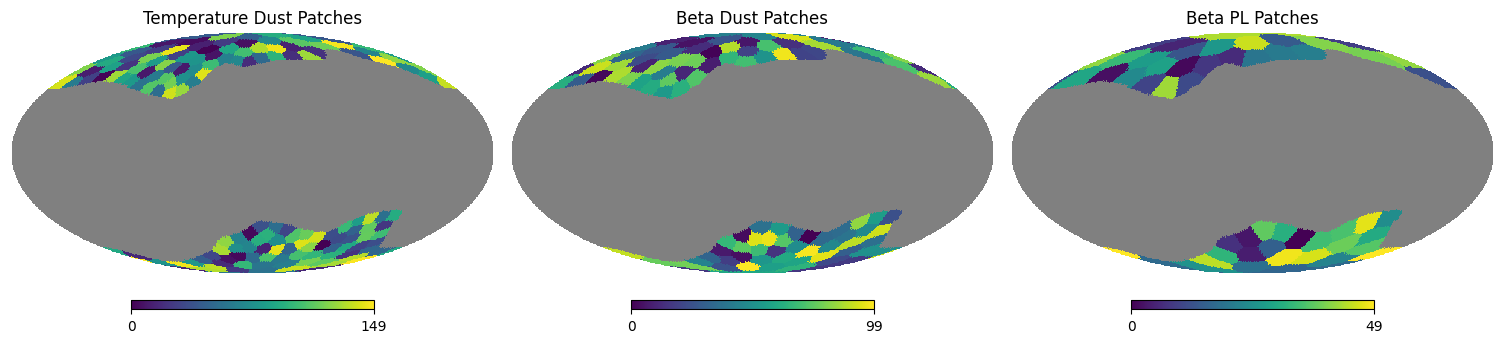

In [ ]:
from jax_healpy import get_cutout_from_mask

temp_dust_patches_count = 50
beta_dust_patches_count = 2000
beta_pl_patches_count = 50
max_centroids = 2000
(indices,) = jnp.where(mask == 1)

temp_dust_patch_indices = get_clusters(
    mask,
    indices,
    temp_dust_patches_count,
    jax.random.PRNGKey(0),
    max_centroids=max_centroids,
)
beta_dust_patch_indices = get_clusters(
    mask,
    indices,
    beta_dust_patches_count,
    jax.random.PRNGKey(0),
    max_centroids=max_centroids,
)
beta_pl_patch_indices = get_clusters(
    mask,
    indices,
    beta_pl_patches_count,
    jax.random.PRNGKey(0),
    max_centroids=max_centroids,
)

params = {
    "beta_dust": jnp.full((temp_dust_patches_count,), 1.54),
    "temp_dust": jnp.full((max_centroids,), 20.0),
    "beta_pl": jnp.full((beta_pl_patches_count,), (-3.0)),
}

patch_indices = {
    "temp_dust_patches": temp_dust_patch_indices,
    "beta_dust_patches": beta_dust_patch_indices,
    "beta_pl_patches": beta_pl_patch_indices,
}


(indices,) = jnp.where(mask == 1)

masked_sky = jax.tree.map(lambda full_map: get_cutout_from_mask(full_map, indices, axis=1), d)
masked_clusters = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int64),
    patch_indices,
)


# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(temp_dust_patch_indices, title="Temperature Dust Patches", sub=(1, 3, 1))
hp.mollview(beta_dust_patch_indices, title="Beta Dust Patches", sub=(1, 3, 2))
hp.mollview(beta_pl_patch_indices, title="Beta PL Patches", sub=(1, 3, 3))

# Display the plot
plt.show()

# Simulate Mixed Sky Data  
Simulate mixed sky data `d` using optimal parameters and cluster configurations. 

In [13]:
dust_nu0 = 150.0
synchrotron_nu0 = 20.0

spectral_cmb_variance = partial(
    spectral_cmb_variance, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)
negative_log_likelihood = partial(
    negative_log_likelihood, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)

spectral_log_likelihood = partial(
    spectral_log_likelihood, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)


N = HomothetyOperator(jnp.ones(1), _in_structure=d.structure)

# Defining Objective Function  
Define the objective function for optimizing sky data by minimizing variance.  
The `compute_minum_variance` function computes the optimal parameters based on Planck mask clusters and spectral data.


In [ ]:
planck_mask = mask
(indices,) = jnp.where(planck_mask == 1)
max_patches = 300
T_d_patches = 150
B_d_patches = 100
B_s_patches = 50

temp_dust_patch_indices = get_clusters(
    planck_mask, indices, T_d_patches, jax.random.PRNGKey(0), max_centroids=max_patches
)
beta_dust_patch_indices = get_clusters(
    planck_mask, indices, B_d_patches, jax.random.PRNGKey(0), max_centroids=max_patches
)
beta_pl_patch_indices = get_clusters(
    planck_mask, indices, B_s_patches, jax.random.PRNGKey(0), max_centroids=max_patches
)

params = {
    "temp_dust": jnp.full((max_patches,), 20.0),
    "beta_dust": jnp.full((max_patches,), 1.54),
    "beta_pl": jnp.full((max_patches,), -3.0),
}

patch_indices = {
    "temp_dust_patches": temp_dust_patch_indices.astype(jnp.int64),
    "beta_dust_patches": beta_dust_patch_indices.astype(jnp.int64),
    "beta_pl_patches": beta_pl_patch_indices.astype(jnp.int64),
}

masked_clusters = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int64),
    patch_indices,
)

N = HomothetyOperator(jnp.ones(1), _in_structure=masked_sky.structure)
negative_log_likelihood(params, nu=nu, d=masked_sky, N=N, patch_indices=masked_clusters)

Array(-22516453.45283415, dtype=float64)

In [ ]:
from functools import partial

import lineax as lx
import optax
from furax import Config

solver = optax.lbfgs()

inverser_options = {
    "solver": lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000),
    "solver_throw": False,
}


(indices,) = jnp.where(mask == 1)

masked_sky = jax.tree.map(lambda full_map: get_cutout_from_mask(full_map, indices, axis=1), d)
masked_noise = HomothetyOperator(jnp.ones(1), _in_structure=masked_sky.structure)


@partial(jax.jit, static_argnums=(5))
def compute_minimum_variance(
    T_d_patches, B_d_patches, B_s_patches, planck_mask, indices, max_patches=25
):
    temp_dust_patch_indices = get_clusters(
        planck_mask,
        indices,
        T_d_patches,
        jax.random.PRNGKey(0),
        max_centroids=max_patches,
    )
    beta_dust_patch_indices = get_clusters(
        planck_mask,
        indices,
        B_d_patches,
        jax.random.PRNGKey(0),
        max_centroids=max_patches,
    )
    beta_pl_patch_indices = get_clusters(
        planck_mask,
        indices,
        B_s_patches,
        jax.random.PRNGKey(0),
        max_centroids=max_patches,
    )

    params = {
        "temp_dust": jnp.full((max_patches,), 20.0),
        "beta_dust": jnp.full((max_patches,), 1.54),
        "beta_pl": jnp.full((max_patches,), -3.0),
    }

    patch_indices = {
        "temp_dust_patches": temp_dust_patch_indices,
        "beta_dust_patches": beta_dust_patch_indices,
        "beta_pl_patches": beta_pl_patch_indices,
    }
    masked_clusters = jax.tree.map(
        lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int64),
        patch_indices,
    )

    with Config(**inverser_options):
        final_params, final_state = optimize(
            params,
            negative_log_likelihood,
            solver,
            max_iter=1000,
            tol=1e-8,
            verbose=False,
            nu=nu,
            N=masked_noise,
            d=masked_sky,
            patch_indices=masked_clusters,
        )

    return spectral_cmb_variance(
        final_params, nu=nu, d=masked_sky, N=masked_noise, patch_indices=masked_clusters
    )


bad_var = compute_minimum_variance(10, 20, 25, mask, indices, max_patches=max_centroids)

# Compute Best Variance  
Compute the best variance using the optimal number of patches for temperature dust, beta dust, and beta PL patches, based on the Planck mask and cluster indices.


In [ ]:
best_var = compute_minimum_variance(
    temp_dust_patches_count,
    beta_dust_patches_count,
    beta_pl_patches_count,
    mask,
    indices,
    max_patches=max_centroids,
)

# Comparison of Variances  
The best variance (`best_var`) is lower than the bad variance (`bad_var`), indicating that the configuration with the optimal number of patches yields a better fit.


In [35]:
print(f"best_var < bad_var : {best_var < bad_var}")
print(f"best_var : {best_var}")
print(f"bad_var : {bad_var}")

best_var < bad_var : False
best_var : 0.975024325072378
bad_var : 0.9748667973539327


In [ ]:
from jax_grid_search import DistributedGridSearch


@jax.jit
def objective_function(T_d_patches, B_d_patches, B_s_patches):
    return compute_minimum_variance(
        T_d_patches,
        B_d_patches,
        B_s_patches,
        mask,
        indices,
        max_patches=max_centroids,
    )


# Put the good values for the grid search
search_space = {
    "T_d_patches": jax.array([50]),
    "B_d_patches": jax.array([1500, 2000]),
    "B_s_patches": jax.array([50]),
}

grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=2, progress_bar=True, log_every=0.1
)

results = grid_search.run()

for keys, values in results.items():
    print(f"{keys} : {values[0]}")

In [1]:
from jax_grid_search import DistributedGridSearch

results = DistributedGridSearch.stack_results("results")
results.keys()

dict_keys(['T_d_patches', 'B_d_patches', 'B_s_patches', 'beta_dust', 'beta_pl', 'temp_dust', 'value'])

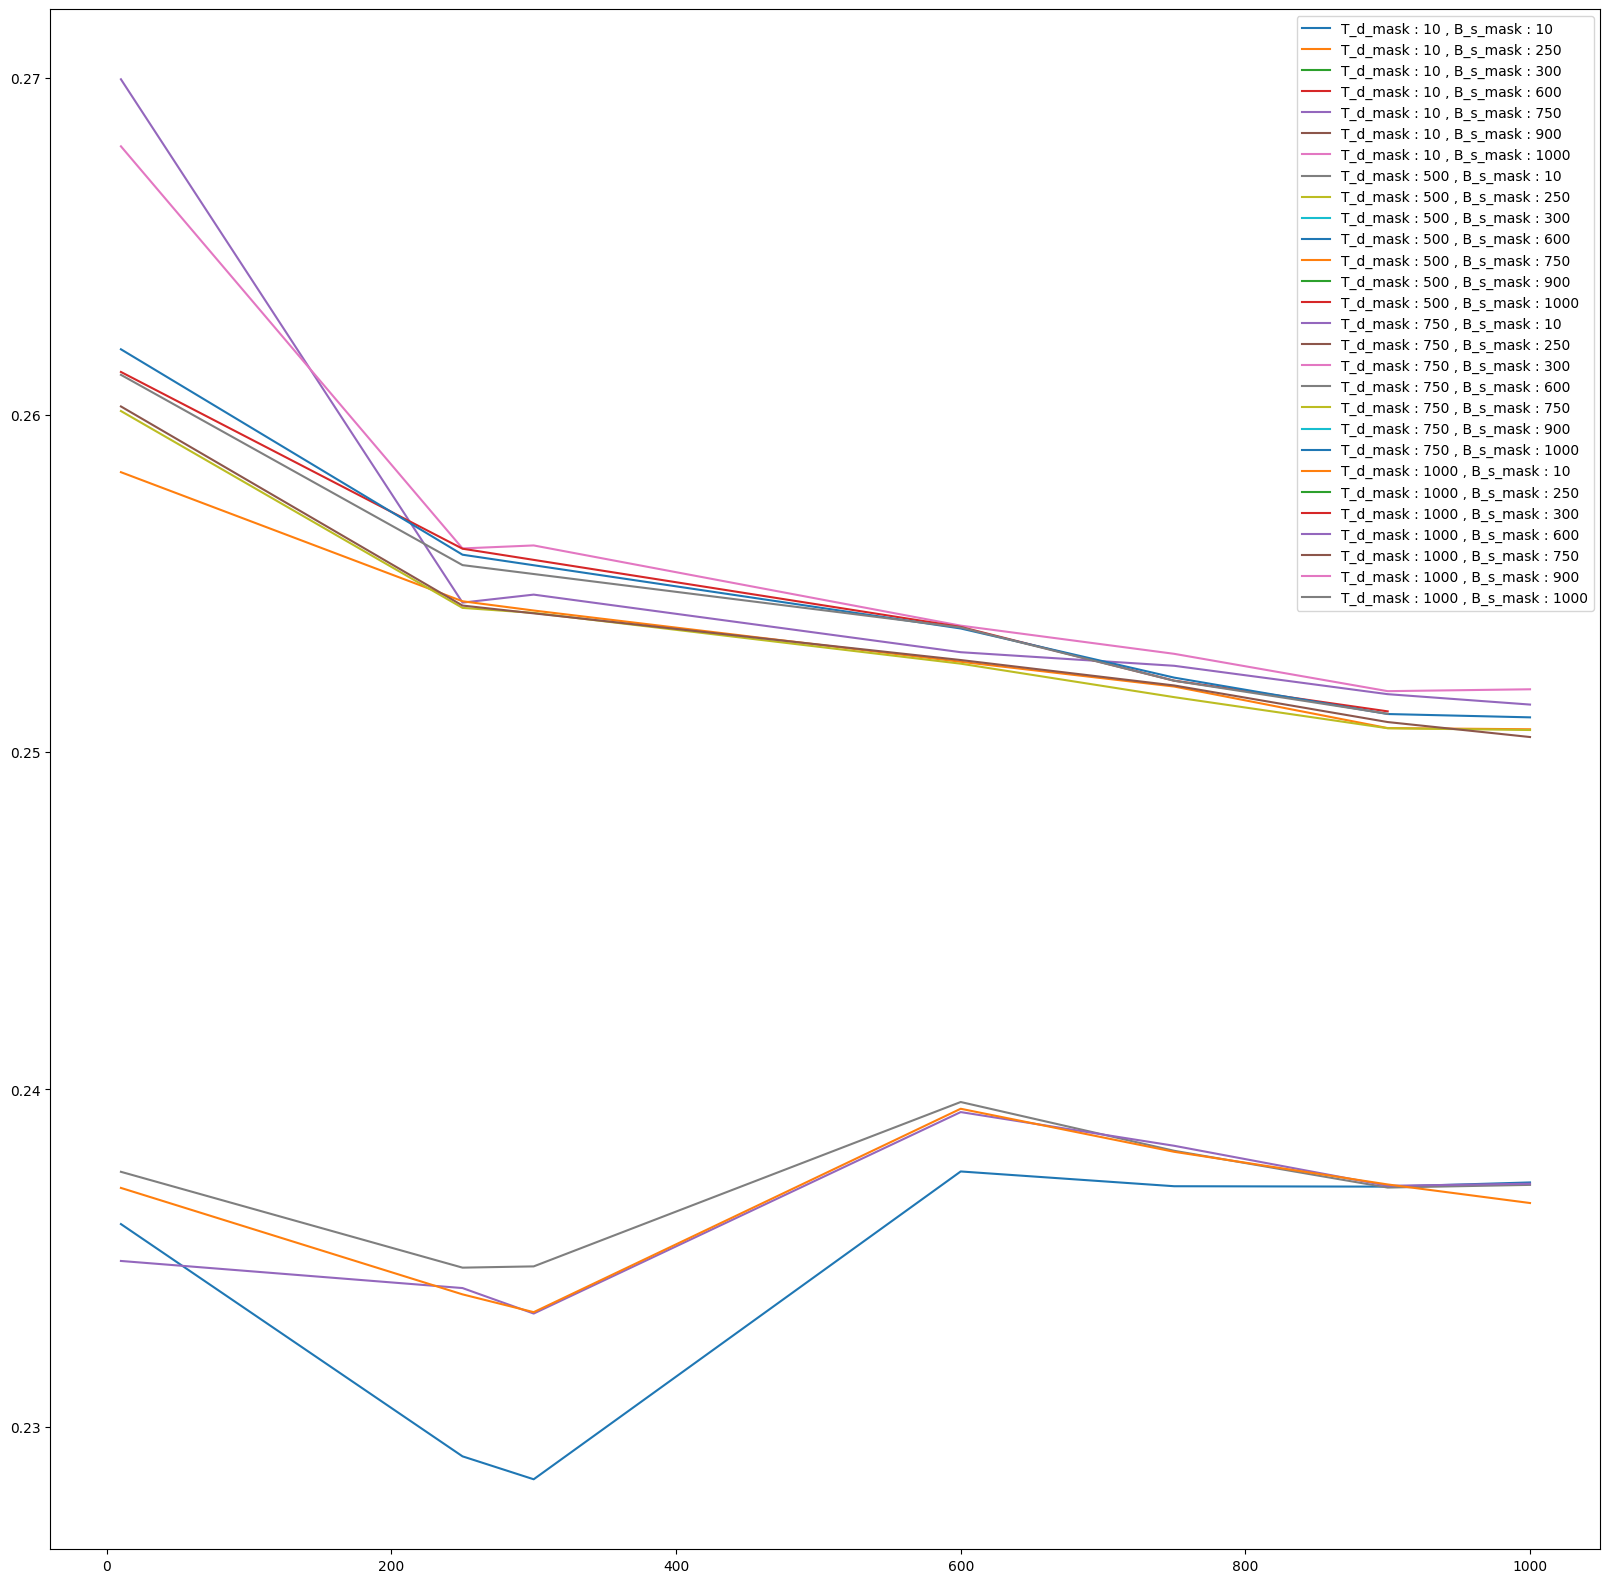

In [12]:
from itertools import product

import jax.numpy as jnp
import matplotlib.pyplot as plt

T_d_patches = results["T_d_patches"]
B_d_patches = results["B_d_patches"]
B_s_patches = results["B_s_patches"]
value = results["value"]

unique_T_d_patches = jnp.unique(T_d_patches)
unique_B_d_patches = jnp.unique(B_d_patches)

plt.figure(figsize=(20, 20))
for T_d_mask, B_d_mask in product(unique_T_d_patches, unique_B_d_patches):
    T_d_B_s_mask = (T_d_patches == T_d_mask) & (B_s_patches == B_d_mask)

    # Sort and index
    filtered_value = value[T_d_B_s_mask]
    filtered_B_d_patches = B_d_patches[T_d_B_s_mask]

    B_d_sorted_args = jnp.argsort(filtered_B_d_patches)
    filtered_value = filtered_value[B_d_sorted_args]
    filtered_B_d_patches = filtered_B_d_patches[B_d_sorted_args]

    plt.plot(
        filtered_B_d_patches,
        filtered_value,
        label=f"T_d_mask : {T_d_mask} , B_s_mask : {B_d_mask}",
    )
    plt.legend()